In [23]:
from glob import glob
import timeit
import pydicom

# I had to install these dependencies to be able to run
# !pip install gdcm>=3.0.10
# !pip install pylibjpeg>=2.0
# !pip install pylibjpeg-libjpeg>=2.1
# !pip install pillow>=10.0

# Time how long it takes to load all DICOM file paths
start_time = timeit.default_timer()
dcm_files = glob("/home/fgj4kw/Downloads/mdai_rsna_project_x9N20BZa_images_2018-07-20-153330/**/*.dcm", recursive=True)
elapsed = timeit.default_timer() - start_time
print(f"Time to load DICOM file paths: {elapsed:.4f} seconds")

# Print number of images
print("There are", len(dcm_files), "images")

# Print the shape of one image
print("These images have a size", pydicom.dcmread(dcm_files[0]).pixel_array.shape)



Time to load DICOM file paths: 15.9536 seconds
There are 30000 images
These images have a size (1024, 1024)


In [8]:
sample_files

NameError: name 'sample_files' is not defined

In [ ]:
dcm_files

In [9]:
!pip install numpy==1.26.4



import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm

# Load all DICOM file paths
dcm_files = glob("/home/fgj4kw/Downloads/mdai_rsna_project_x9N20BZa_images_2018-07-20-153330/**/*.dcm", recursive=True)

# Sample size for EDA to keep it fast (optional)
sample_files = dcm_files[:1000]

# Initialize lists for metadata
image_shapes = []
pixel_means = []
pixel_stds = []
modalities = []
patient_ids = []

# Loop through a sample of DICOM files and collect metadata
for path in tqdm(sample_files, desc="Analyzing DICOM metadata"):
    ds = pydicom.dcmread(path)
    
    # Extract image array
    img = ds.pixel_array
    image_shapes.append(img.shape)
    pixel_means.append(np.mean(img))
    pixel_stds.append(np.std(img))
    
    # Extract metadata (some may not exist in all files)
    modalities.append(getattr(ds, 'Modality', 'Unknown'))
    patient_ids.append(getattr(ds, 'PatientID', 'Unknown'))

# -------------------------------------
# 🧾 1. Summary of the dataset
print("Total DICOM files available:", len(dcm_files))
print("Sample used for EDA:", len(sample_files))
print("Unique image shapes found in sample:", set(image_shapes))
print("Unique modalities found:", set(modalities))
print("Unique patients in sample:", len(set(patient_ids)))

# -------------------------------------
# 📚 2. Data Dictionary (for audience)
data_dict = {
    "pixel_array": "2D numpy array of raw pixel values",
    "Modality": "Imaging modality used (e.g., CT, MR)",
    "PatientID": "De-identified unique patient identifier",
    "pixel_mean": "Mean pixel intensity of the image",
    "pixel_std": "Standard deviation of pixel intensity"
}
print("\nData Dictionary:")
for key, val in data_dict.items():
    print(f" - {key}: {val}")


Defaulting to user installation because normal site-packages is not writeable


Analyzing DICOM metadata: 100%|██████████| 1000/1000 [00:33<00:00, 29.52it/s]

Total DICOM files available: 30000
Sample used for EDA: 1000
Unique image shapes found in sample: {(1024, 1024)}
Unique modalities found: {'CR'}
Unique patients in sample: 1000

Data Dictionary:
 - pixel_array: 2D numpy array of raw pixel values
 - Modality: Imaging modality used (e.g., CT, MR)
 - PatientID: De-identified unique patient identifier
 - pixel_mean: Mean pixel intensity of the image
 - pixel_std: Standard deviation of pixel intensity


Pixel data (first image):
[[49 42 34 ... 54 50 30]
 [29 23 16 ... 25 23  7]
 [18 13  8 ...  9  9  0]
 ...
 [ 1  1  1 ...  1  0  0]
 [ 1  1  1 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]]


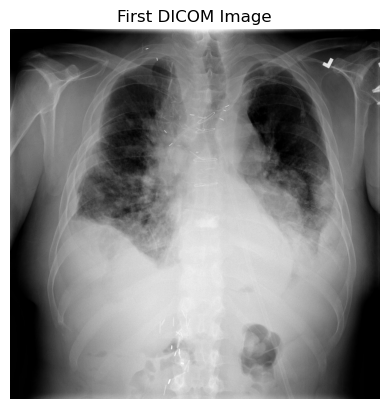

In [25]:
# View raw pixel data of the first image in the sample
first_image = pydicom.dcmread(sample_files[0]).pixel_array
print("Pixel data (first image):")
print(first_image)

# Optional: view as an image
plt.imshow(first_image, cmap='gray')
plt.title("First DICOM Image")
plt.axis('off')
plt.show()



In [27]:
!pip install tensorflow

# Simulate labels based on file names (assuming 'pneumonia' in file name means pneumonia case)
labels = ['pneumonia' if 'pneumonia' in file else 'normal' for file in sample_files]


Defaulting to user installation because normal site-packages is not writeable


In [26]:
def preprocess_dicom_image(dicom_path, target_size=(224, 224)):
    # Read DICOM file
    ds = pydicom.dcmread(dicom_path)
    img = ds.pixel_array
    
    # Resize the image
    img = tf.image.resize(img, target_size)
    
    # Add channel dimension (since images are grayscale, we replicate the channel for 3 channels)
    img = np.repeat(img[..., np.newaxis], 3, -1)
    
    # Normalize image to range [0, 1]
    img = img.astype(np.float32) / np.max(img)
    
    # Convert to array (in case it's needed)
    img = img_to_array(img)
    
    return img


In [30]:
import pydicom
import pandas as pd
from pathlib import Path
from tqdm import tqdm

data = []

for path in tqdm(dcm_files, desc="Extracting DICOM labels"):
    ds = pydicom.dcmread(path)
    patient_id = Path(path).stem

    # Try a few fields that might contain labels
    label = None
    if hasattr(ds, 'SeriesDescription'):
        label = ds.SeriesDescription
    elif hasattr(ds, 'StudyDescription'):
        label = ds.StudyDescription
    elif '0008,103e' in ds:  # Series Description
        label = str(ds['0008,103e'].value)
    elif '0020,4000' in ds:  # Image Comments
        label = str(ds['0020,4000'].value)
    else:
        label = "Unknown"

    data.append({
        'patientId': patient_id,
        'label_raw': label,
        'dicom_path': path
    })

df_labels = pd.DataFrame(data)
print(df_labels.head())


Extracting DICOM labels: 100%|██████████| 30000/30000 [08:06<00:00, 61.71it/s]

                                           patientId label_raw  \
0  1.2.276.0.7230010.3.1.4.8323329.2178.151787429...  view: PA   
1  1.2.276.0.7230010.3.1.4.8323329.1560.151787429...  view: AP   
2  1.2.276.0.7230010.3.1.4.8323329.8113.151787433...  view: PA   
3  1.2.276.0.7230010.3.1.4.8323329.12087.15178743...  view: AP   
4  1.2.276.0.7230010.3.1.4.8323329.8373.151787433...  view: PA   

                                          dicom_path  
0  /home/fgj4kw/Downloads/mdai_rsna_project_x9N20...  
1  /home/fgj4kw/Downloads/mdai_rsna_project_x9N20...  
2  /home/fgj4kw/Downloads/mdai_rsna_project_x9N20...  
3  /home/fgj4kw/Downloads/mdai_rsna_project_x9N20...  
4  /home/fgj4kw/Downloads/mdai_rsna_project_x9N20...  


In [11]:
dcm_files[0]

'/home/fgj4kw/Downloads/mdai_rsna_project_x9N20BZa_images_2018-07-20-153330/1.2.276.0.7230010.3.1.2.8323329.2178.1517874295.72554/1.2.276.0.7230010.3.1.3.8323329.2178.1517874295.72553/1.2.276.0.7230010.3.1.4.8323329.2178.1517874295.72555.dcm'

In [36]:
import pydicom

sample_path = dcm_files[0]
ds = pydicom.dcmread(sample_path)
print(ds)



Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 200
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.2178.1517874295.72555
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2178.1517874295.72555
(0008,0020) Study Date                          DA: '19010101'
(0008,0030) Study Time                      

In [13]:
import json

with open("pneumonia-challenge-annotations-adjudicated-kaggle_2018.json") as f:
    data = json.load(f)
    
print(data['datasets'][0].keys())
data['datasets'][0]['studies']
print(data['datasets'][0]['annotations'][0])


dict_keys(['id', 'type', 'createdAt', 'updatedAt', 'name', 'description', 'studies', 'annotations'])
{'id': 'A_e5227e', 'createdAt': '2018-03-24T23:00:19.392Z', 'createdById': 'U_rk3', 'updatedAt': '2018-03-24T23:00:19.398Z', 'updatedById': 'U_rk3', 'machineLearningModelId': None, 'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.6749.1517874327.608586', 'SeriesInstanceUID': '1.2.276.0.7230010.3.1.3.8323329.6749.1517874327.608585', 'SOPInstanceUID': '1.2.276.0.7230010.3.1.4.8323329.6749.1517874327.608587', 'labelId': 'L_1el', 'annotationNumber': None, 'height': None, 'width': None, 'data': None, 'note': None, 'radlexTagIds': [], 'reviewsPositiveCount': 0, 'reviewsNegativeCount': 0}


In [30]:
labels = dict()
for my_dict in data["datasets"][0]["annotations"]:
    labels[my_dict["StudyInstanceUID"]] = my_dict["labelId"] 

In [38]:
for label in data['labelClasses']:
    print(f"{label['id']}: {label['name']}")


KeyError: 'labelClasses'

In [23]:
data["datasets"][0]["studies"]

[{'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.7188.1517874330.219668',
  'number': 7,
  'findings': ''},
 {'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.1747.1517874292.605927',
  'number': 3,
  'findings': ''},
 {'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.29958.1517874494.781610',
  'number': 9,
  'findings': ''},
 {'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.15365.1517874385.310323',
  'number': 29987,
  'findings': ''},
 {'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.8643.1517874338.580515',
  'number': 4,
  'findings': ''},
 {'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.24972.1517874460.357770',
  'number': 29997,
  'findings': ''},
 {'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.5832.1517874318.477656',
  'number': 29992,
  'findings': ''},
 {'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.4475.1517874307.936344',
  'number': 6,
  'findings': ''},
 {'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.19010.1517874414.7

In [12]:
for label in data['labelClasses']:
    print(f"{label['id']} → {label['name']}")


KeyError: 'labelClasses'